<a href="https://colab.research.google.com/github/nimeshayasith/Computer_vision_Assignment/blob/main/4624_Question_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- STEP 1: RECONNECT GOOGLE DRIVE (Fixes Error 107) ---
from google.colab import drive
import os

# Force a remount to re-establish the broken connection
drive.mount('/content/drive', force_remount=True)

# Point back to your project folder
project_path = '/content/drive/MyDrive/CV_Assessment_01'
if os.path.exists(project_path):
    os.chdir(project_path)
    print("Drive reconnected and directory set successfully!")
else:
    print("Drive mounted, but folder not found. Please check your folder name.")

Mounted at /content/drive
Drive reconnected and directory set successfully!


In [2]:
import os

# Update this path if you named your folder something else
project_path = '/content/drive/MyDrive/CV_Assessment_01'

# Change the current working directory
os.chdir(project_path)

# Verify you are in the right place
print("Current Working Directory:", os.getcwd())
print("Files in Dataset folder:", os.listdir('Dataset'))

Current Working Directory: /content/drive/MyDrive/CV_Assessment_01
Files in Dataset folder: ['IPCV_ ASSIGNMENT_01_DATABASE.zip', 'IPCV_ ASSIGNMENT_01_DATABASE']


Embedding Watermark...
Extracting Watermark...


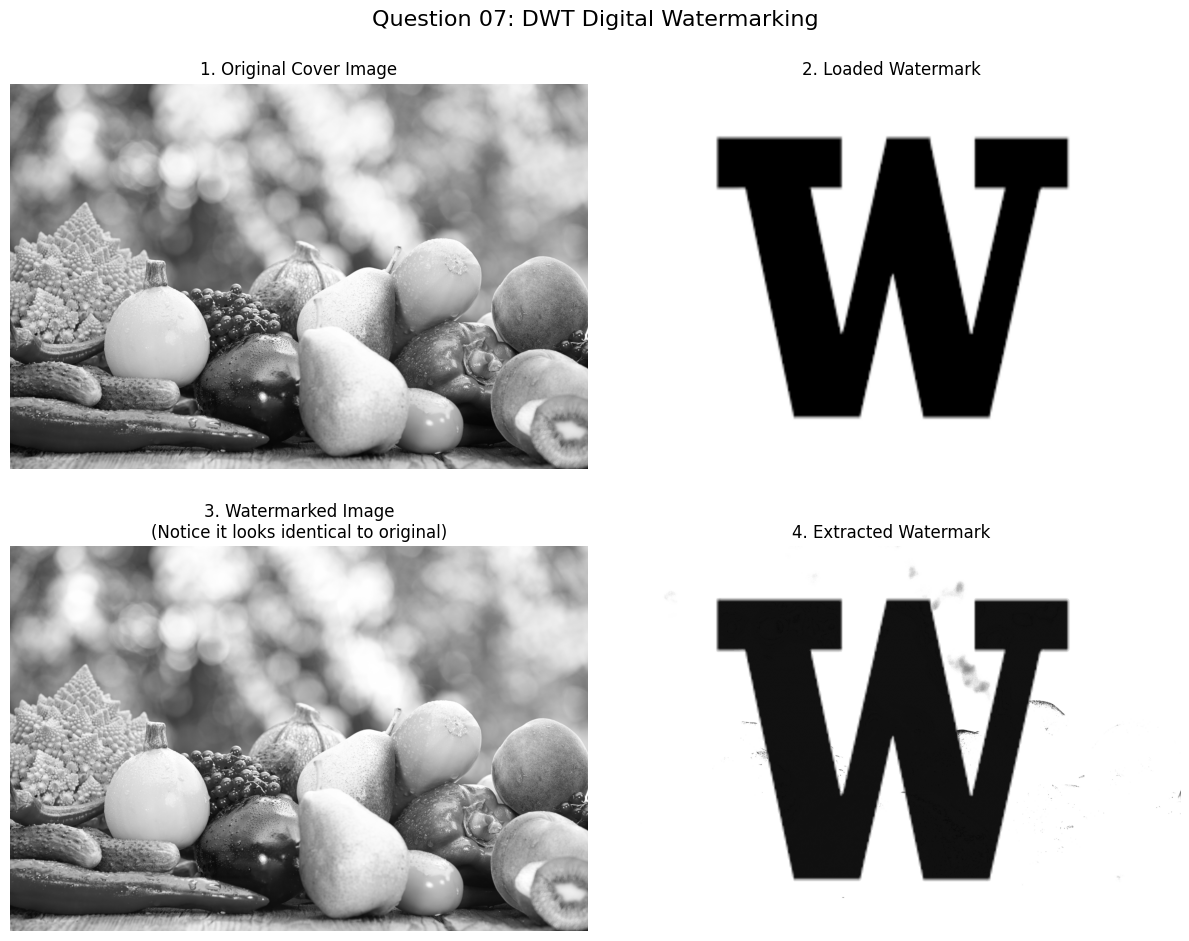

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt

# --- 1. Load and Prepare the Cover Image & Watermark ---
# Define base path to keep the code clean
base_path = 'Dataset/IPCV_ ASSIGNMENT_01_DATABASE/Images_ For_Preliminary_Part/'
img_3_path = base_path + 'Image_3.jpg'
watermark_path = base_path + 'watermark.png'

# Load both images in grayscale
cover_image = cv2.imread(img_3_path, cv2.IMREAD_GRAYSCALE)
watermark_img = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)

if cover_image is None:
    print(f"Error: Could not load cover image at {img_3_path}.")
elif watermark_img is None:
    print(f"Error: Could not load watermark image at {watermark_path}.")
else:
    # Ensure cover image dimensions are even numbers for perfect DWT/IDWT reconstruction
    h, w = cover_image.shape
    cover_image = cv2.resize(cover_image, (w - w%2, h - h%2))
    h, w = cover_image.shape

    # --- 2. Prepare the Loaded Watermark ---
    # The watermark must be the exact size of the DWT approximation band (cA),
    # which is exactly half the size of the cover image.
    wm_h, wm_w = h // 2, w // 2

    # Resize the loaded watermark to match the cA band capacity
    watermark = cv2.resize(watermark_img, (wm_w, wm_h))

    # Normalize watermark to be between 0 and 1 for easier mathematical scaling
    watermark_normalized = watermark / 255.0

    # --- 3. EMBEDDING PROCESS ---
    print("Embedding Watermark...")
    # Step A: Perform DWT on the cover image (using Haar wavelet)
    coeffs_cover = pywt.dwt2(cover_image, 'haar')
    cA_cover, (cH_cover, cV_cover, cD_cover) = coeffs_cover

    # Step B: Embed the watermark into the Approximation (cA) band
    # alpha controls the watermark strength.
    # Too high = visible distortion. Too low = lost during extraction.
    alpha = 15.0
    cA_watermarked = cA_cover + (alpha * watermark_normalized)

    # Step C: Reconstruct the image (IDWT)
    coeffs_watermarked = (cA_watermarked, (cH_cover, cV_cover, cD_cover))
    watermarked_image = pywt.idwt2(coeffs_watermarked, 'haar')

    # Clip to valid pixel range
    watermarked_image_disp = np.clip(watermarked_image, 0, 255).astype(np.uint8)

    # --- 4. EXTRACTION PROCESS ---
    print("Extracting Watermark...")
    # Step A: Perform DWT on the newly watermarked image
    coeffs_extracted = pywt.dwt2(watermarked_image_disp, 'haar')
    cA_extracted, _ = coeffs_extracted

    # Step B: Perform DWT on the original cover image (owner keeps this safe)
    coeffs_orig = pywt.dwt2(cover_image, 'haar')
    cA_orig, _ = coeffs_orig

    # Step C: Isolate the watermark mathematically -> W = (cA_extracted - cA_orig) / alpha
    extracted_watermark = (cA_extracted - cA_orig) / alpha

    # --- PLOTTING FOR REPORT ---
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Question 07: DWT Digital Watermarking", fontsize=16)

    axes[0, 0].imshow(cover_image, cmap='gray')
    axes[0, 0].set_title("1. Original Cover Image")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(watermark, cmap='gray')
    axes[0, 1].set_title("2. Loaded Watermark")
    axes[0, 1].axis('off')

    axes[1, 0].imshow(watermarked_image_disp, cmap='gray')
    axes[1, 0].set_title("3. Watermarked Image\n(Notice it looks identical to original)")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(extracted_watermark, cmap='gray')
    axes[1, 1].set_title("4. Extracted Watermark")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()